In [ ]:
!unzip /content/drive/MyDrive/APS360Project/archive/cropped_dataset/A.zip

In [1]:
# initialization
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import os
drive.mount('/content/drive')
import numpy as np
import time
import pandas as pd
from matplotlib.image import imread
from torchvision.io import read_image
from torchsummary import summary
import torch.optim as optim

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Mounted at /content/drive


In [3]:
# path declare
master_path = '/content/drive/MyDrive/APS360Project/archive/cropped_dataset/'
csv_path = master_path + "cropped_proportion.csv"
train_csv_path = master_path + "cropped_proportion_train.csv"
val_csv_path = master_path + "cropped_proportion_valid.csv"
test_csv_path = master_path + "cropped_proportion_test.csv"
class_dict_path = master_path + "class_dict.csv"
image_folder_path = '/content/A'
total_info = pd.read_csv(csv_path)
train_info = pd.read_csv(train_csv_path)
val_info = pd.read_csv(val_csv_path)
test_info = pd.read_csv(test_csv_path)

In [4]:
print(len(total_info['image_id']))
print(len(train_info['image_id']), len(train_info['image_id'])/len(total_info['image_id']))
print(len(val_info['image_id']), len(val_info['image_id'])/len(total_info['image_id']))
print(len(test_info['image_id']), len(test_info['image_id'])/len(total_info['image_id']))

12848
9616 0.7484433374844334
1616 0.12577833125778332
1616 0.12577833125778332


In [5]:
classes = pd.read_csv(class_dict_path)
list(classes['name'])

['urban_land',
 'agriculture_land',
 'rangeland',
 'forest_land',
 'water',
 'barren_land',
 'unknown']

In [6]:
class DataFull(object):  # Class names typically use CamelCase
    def __init__(self, csv_info, image_folder_path, transform_input, transform_output):
        self.img_info = csv_info
        self.image_folder_path = image_folder_path
        self.transform_input = transform_input
        self.transform_output = transform_output

    def __len__(self):
        return len(self.img_info)  # Assuming img_info is a DataFrame or similar structure

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder_path, self.img_info['sat_image_path'][idx])
        image = read_image(img_path)
        label_path = os.path.join(self.image_folder_path, self.img_info['mask_path'][idx])
        label = read_image(label_path)
        if self.transform_input:
            image = self.transform_input(image)
        if self.transform_output:
            label = self.transform_output(label)
        return image, label

In [7]:
mean= [0.4112, 0.3803, 0.2822]
std= [0.1094, 0.0850, 0.0718]
# tensor([0.4112, 0.3803, 0.2822]) tensor([0.1094, 0.0849, 0.0718])

transform_input = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         transforms.Normalize(mean, std),
         transforms.Resize((256,256))])

transform_output = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         transforms.Resize((256,256))])

train_dataset = DataFull(train_info, image_folder_path, transform_input, transform_output)
val_dataset = DataFull(val_info, image_folder_path, transform_input, transform_output)
test_dataset = DataFull(test_info, image_folder_path,transform_input, transform_output)

In [ ]:
train_set = []
val_set = []
test_set = []

for i in range(int(len(train_info))):  # Assuming train_dataset is an instance of DataFull
    image, label = train_dataset[i]  # Use subscript notation
    train_set.append((image, label))
    print(i)
print("finish train set")

for i in range(int(len(val_info))):
  image, label = val_dataset[i]
  val_set.append((image, label))
print("finish val set")

for i in range(int(len(test_info))):
  image, label = test_dataset[i]
  test_set.append((image, label))
print("finish test set")

In [ ]:
print(train_set[0])

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [64]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1 ,
                                            shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)

In [ ]:
k = 0
for i, data in enumerate(train_loader, 0):
    k = k+1
    inputs, labels = data
    print(inputs, labels)
    if k == 1:
        break

In [12]:
def model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


In [16]:
def train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device):
    autoencoder.to(device)
    autoencoder.train()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print("Training Start:")
    start_time = time.time()
    for epoch in range(num_epochs):
        # Training
        running_train_loss = 0.0
        total_pixels_train = 0
        correct_pixels_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = autoencoder(inputs).to(device)
            batch_loss = criterion(outputs, labels)

            # Backward pass and optimization
            batch_loss.backward()
            optimizer.step()

            running_train_loss += batch_loss.item()

            # Calculate accuracy
            total_pixels_train += inputs.numel()
            correct_pixels_train += torch.sum(torch.abs(outputs - labels) < 0.05).item()

        train_accuracy = correct_pixels_train / total_pixels_train
        train_accuracies.append(train_accuracy)
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        autoencoder.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        total_pixels_val = 0
        correct_pixels_val = 0

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val = inputs_val.to(device)
                labels_val = labels_val.to(device)
                outputs_val = autoencoder(inputs_val).to(device)
                val_loss = criterion(outputs_val, labels_val)
                running_val_loss += val_loss.item()

                # Calculate accuracy
                total_pixels_val += inputs_val.numel()
                correct_pixels_val += torch.sum(torch.abs(outputs_val - labels_val) < 0.05).item()

        val_accuracy = correct_pixels_val / total_pixels_val
        val_accuracies.append(val_accuracy)
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        model_path = "/content/trial_3/" + model_name("autoencoder", batch_size, learning_rate, epoch)
        # Print statistics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy}")
        #torch.save(autoencoder.state_dict(), model_path)
        autoencoder.train()

    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    autoencoder.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    total_pixels_test = 0
    correct_pixels_test = 0

    with torch.no_grad():
        for inputs_test, labels_test in test_loader:
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)
            outputs_test = autoencoder(inputs_test).to(device)
            test_loss = criterion(outputs_test, labels_test)
            running_test_loss += test_loss.item()

            # Calculate accuracy
            total_pixels_test += inputs_test.numel()
            correct_pixels_test += torch.sum(torch.abs(outputs_test - labels_test) < 0.05).item()

    final_test_accuracy = correct_pixels_test / total_pixels_test
    final_test_loss = running_test_loss / len(test_loader)
    print("final training accuracy: ", train_accuracy, "final training loss:", avg_train_loss)
    print("final validation accuracy: ", val_accuracy, "final validation loss:", avg_val_loss)
    print("final test accuracy: ", final_test_accuracy, "final test loss:", final_test_loss)

    np.savetxt("{}_train_err.csv".format(model_path), train_accuracies)
    np.savetxt("{}_train_loss.csv".format(model_path), train_losses)
    np.savetxt("{}_val_err.csv".format(model_path), val_accuracies)
    np.savetxt("{}_val_loss.csv".format(model_path), val_losses)



    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.grid(True)
    plt.show()



    return train_losses, val_losses, train_accuracies, val_accuracies

In [68]:
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder_3_0(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(Autoencoder_3_0, self).__init__()
        # Encoder

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 16, 16, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2, padding=0),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2, padding=0),
        )


        self.dec1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=0),
            nn.LeakyReLU(True),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(True),
            nn.Dropout(dropout_rate),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(16, 3, 16, stride=2, padding=1, output_padding=0),
            nn.LeakyReLU(True),
            nn.Sigmoid(),
        )


    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)

        dec1 = self.dec1(enc3)
        # Resize and add skip connection from enc2
        dec1 = F.interpolate(dec1, size=enc2.size()[2:]) + enc2
        # Assuming dec2 corresponds to the decoder layer after dec1
        dec2 = self.dec2(dec1)
        # Resize and add skip connection from enc1
        dec2 = F.interpolate(dec2, size=enc1.size()[2:]) + enc1
        # Assuming dec3 corresponds to the final decoder layer
        x = self.dec3(dec2)
        return x

In [69]:
import torch
import torchsummary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder_3_0().to(device)
summary(model, (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 122, 122]          12,304
              ReLU-2         [-1, 16, 122, 122]               0
         MaxPool2d-3           [-1, 16, 61, 61]               0
            Conv2d-4           [-1, 32, 30, 30]          12,832
              ReLU-5           [-1, 32, 30, 30]               0
           Dropout-6           [-1, 32, 30, 30]               0
            Conv2d-7           [-1, 64, 15, 15]          18,496
              ReLU-8           [-1, 64, 15, 15]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
             ReLU-10            [-1, 128, 8, 8]               0
        MaxPool2d-11            [-1, 128, 4, 4]               0
         Upsample-12            [-1, 128, 8, 8]               0
  ConvTranspose2d-13           [-1, 64, 15, 15]          73,792
        LeakyReLU-14           [-1, 64,

In [ ]:
'''
25s 一组
'''

Training Start:
Epoch 1/300, Train Loss: 0.17906129948402705, Train Accuracy: 0.1843264850060013, Val Loss: 0.16431141325405665, Val Accuracy: 0.2483067748570206
Epoch 2/300, Train Loss: 0.14899356780867828, Train Accuracy: 0.304081065748641, Val Loss: 0.14635199521269118, Val Accuracy: 0.27737293621101
Epoch 3/300, Train Loss: 0.1297306451750429, Train Accuracy: 0.3748648162689463, Val Loss: 0.1297728078705924, Val Accuracy: 0.3575608218857164
Epoch 4/300, Train Loss: 0.12216410197709736, Train Accuracy: 0.39998990882454616, Val Loss: 0.12321153176682335, Val Accuracy: 0.36262335635647913
Epoch 5/300, Train Loss: 0.11851692082066285, Train Accuracy: 0.4051237227978868, Val Loss: 0.12264699808188848, Val Accuracy: 0.32757624698550786
Epoch 6/300, Train Loss: 0.11503952976904418, Train Accuracy: 0.4116181348736129, Val Loss: 0.11416083574295044, Val Accuracy: 0.3453749194003568
Epoch 7/300, Train Loss: 0.11184549135597129, Train Accuracy: 0.40490870652963107, Val Loss: 0.119349959705557

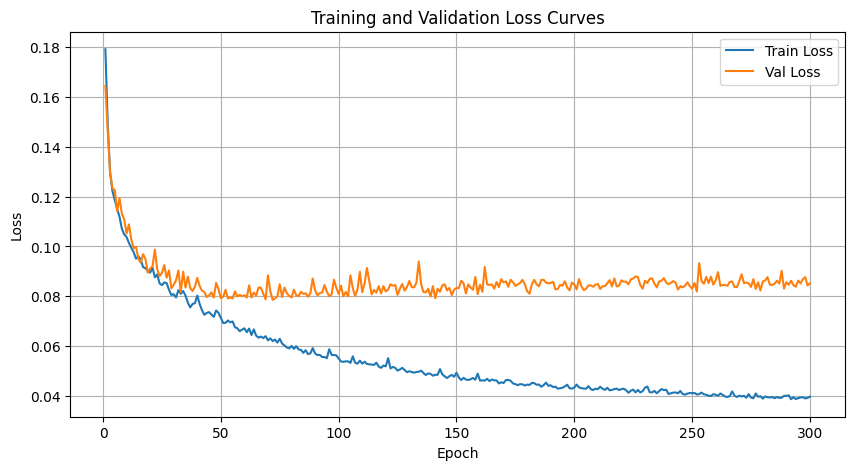

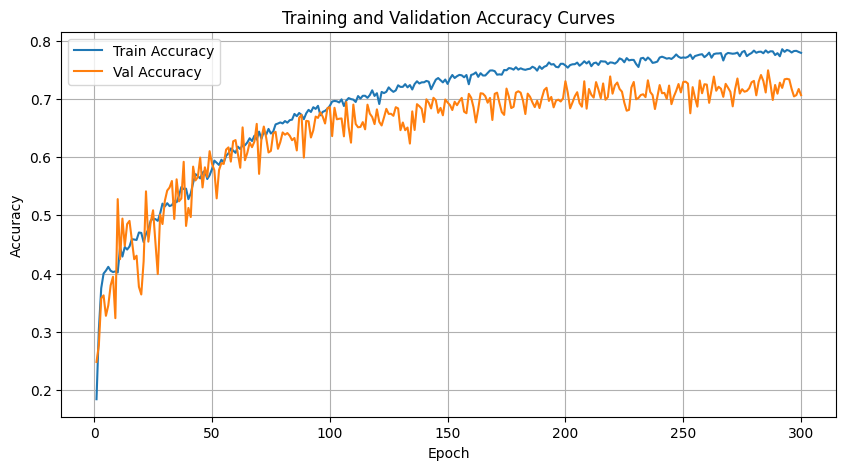

In [70]:
num_epochs = 300
learning_rate = 0.0007
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder_3_0()  # Instantiate your autoencoder model
criterion = nn.MSELoss()  # Define the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)  # Define the optimizer

formal_trial_1 = train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device)

In [40]:
import pickle

with open('Autoencoder_4_0.pkl', 'wb') as f:
    pickle.dump(autoencoder, f)

In [ ]:
num_epochs = 100
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder_3_0()  # Instantiate your autoencoder model
criterion = nn.MSELoss()  # Define the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)  # Define the optimizer

formal_trial_1 = train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device)

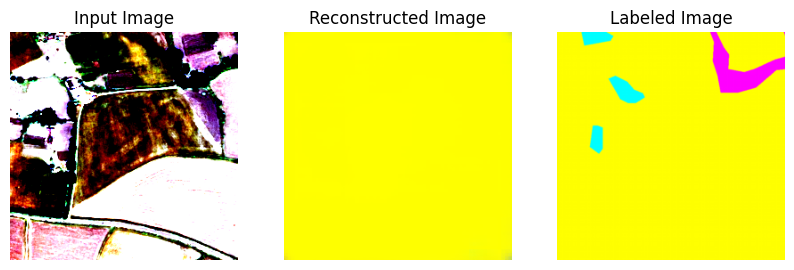

In [54]:
output_image(loaded_model, train_loader, device)

In [141]:
class Autoencoder_3_1(nn.Module):
   def __init__(self, dropout_rate=0.2):
       super(Autoencoder_3_1, self).__init__()
       # Encoder
       self.enc1 = nn.Sequential(
           nn.Conv2d(3, 16, 10, stride=2, padding=1),
           nn.ReLU(True),
           nn.MaxPool2d(2, stride=2, padding=0),
       )
       self.enc2 = nn.Sequential(
           nn.Conv2d(16, 32, 10, stride=2, padding=1),
           nn.ReLU(True),
           nn.Dropout(dropout_rate),
           nn.MaxPool2d(2, stride=2, padding=0),
       )
       self.enc3 = nn.Sequential(
           nn.Conv2d(32, 64, 3, stride=2, padding=1),
           nn.ReLU(True),
           nn.Dropout(dropout_rate),
           nn.MaxPool2d(2, stride=2, padding=0),
       )
       self.enc4 = nn.Sequential(
           nn.Conv2d(64, 128, 3),
           nn.ReLU(True),
       )

       # Decoder
       self.dec1 = nn.Sequential(
           nn.ConvTranspose2d(128, 64, 3),
           nn.LeakyReLU(True),
       )
       self.dec2 = nn.Sequential(
           nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding = 1),
           nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=0),
           nn.LeakyReLU(True),
           )
       self.dec3 = nn.Sequential(
           nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding = 1),
           nn.ConvTranspose2d(32, 16, 10, stride=2, padding=1, output_padding=1),
           nn.LeakyReLU(True),
           nn.Dropout(dropout_rate),
       )
       self.dec4 = nn.Sequential(
           nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding = 1),
           nn.ConvTranspose2d(16, 3, 12, stride=2, padding=1, output_padding=0),
           nn.LeakyReLU(True),
           nn.Sigmoid(),
       )


   def forward(self, x):
       # Encoder
       enc1 = self.enc1(x)
       enc2 = self.enc2(enc1)
       enc3 = self.enc3(enc2)
       enc4 = self.enc4(enc3)

       # Decoder with skip connections
       dec1 = self.dec1(enc4)
       # Ensure matching dimensions for skip connection
       dec1 = F.interpolate(dec1, size=enc3.size()[2:]) + enc3
       dec2 = self.dec2(dec1)
       # Ensure matching dimensions for skip connection
       dec2 = F.interpolate(dec2, size=enc2.size()[2:]) + enc2
       dec3 = self.dec3(dec2)
       # Ensure matching dimensions for skip connection
       dec3 = F.interpolate(dec3, size=enc1.size()[2:]) + enc1
       x = self.dec4(dec3)
       return x


In [142]:
import torch
import torchsummary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder_3_1().to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 125, 125]           4,816
              ReLU-2         [-1, 16, 125, 125]               0
         MaxPool2d-3           [-1, 16, 62, 62]               0
            Conv2d-4           [-1, 32, 28, 28]          51,232
              ReLU-5           [-1, 32, 28, 28]               0
           Dropout-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8             [-1, 64, 7, 7]          18,496
              ReLU-9             [-1, 64, 7, 7]               0
          Dropout-10             [-1, 64, 7, 7]               0
        MaxPool2d-11             [-1, 64, 3, 3]               0
           Conv2d-12            [-1, 128, 1, 1]          73,856
             ReLU-13            [-1, 128, 1, 1]               0
  ConvTranspose2d-14             [-1, 6

Training Start:
Epoch 1/250, Train Loss: 0.1781029587513522, Train Accuracy: 0.1983460946276131, Val Loss: 0.1673413919551032, Val Accuracy: 0.24082538869121287
Epoch 2/250, Train Loss: 0.14908534288406372, Train Accuracy: 0.2696355961457399, Val Loss: 0.1509985966341836, Val Accuracy: 0.26360222844794245
Epoch 3/250, Train Loss: 0.13375582173466682, Train Accuracy: 0.3335286583162584, Val Loss: 0.13985371589660645, Val Accuracy: 0.34554703086122823
Epoch 4/250, Train Loss: 0.12099976935668995, Train Accuracy: 0.3876143935251686, Val Loss: 0.12573188649756567, Val Accuracy: 0.33808777749341706
Epoch 5/250, Train Loss: 0.11388227520020384, Train Accuracy: 0.4235293022870885, Val Loss: 0.12203885614871979, Val Accuracy: 0.3412834645891347
Epoch 6/250, Train Loss: 0.10987547588975806, Train Accuracy: 0.4468779011164119, Val Loss: 0.11368551531008311, Val Accuracy: 0.40612319279031783
Epoch 7/250, Train Loss: 0.10466683950079114, Train Accuracy: 0.4675911301979408, Val Loss: 0.112079777887

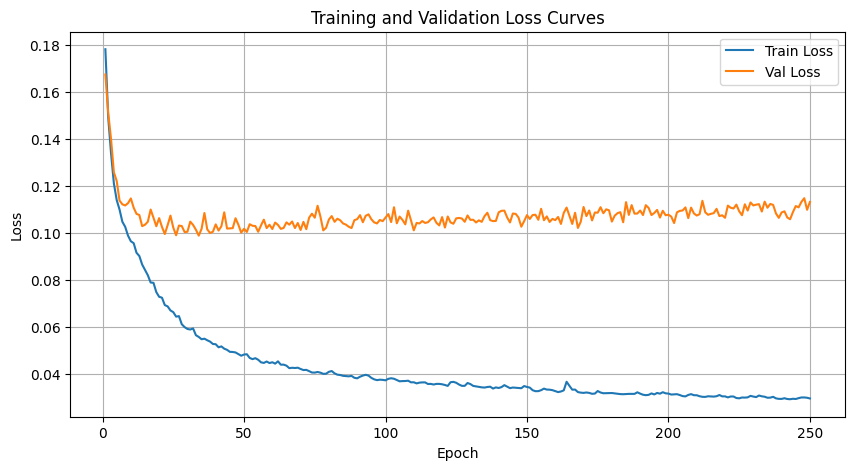

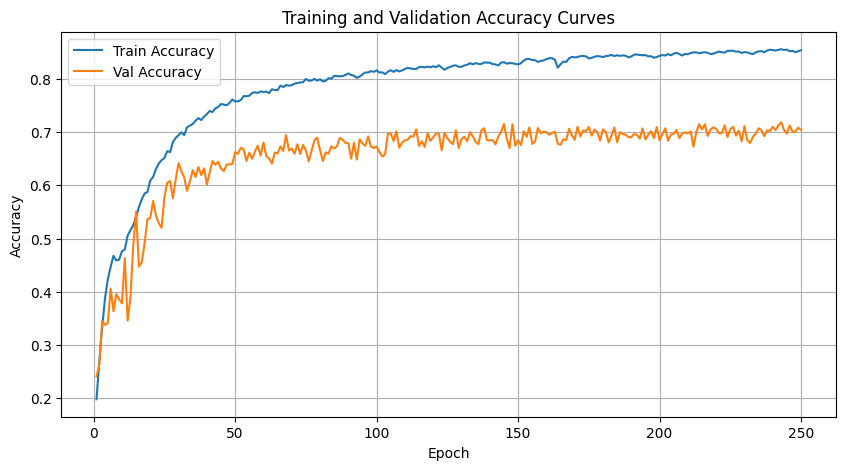

In [83]:
num_epochs = 250
learning_rate = 0.0007
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder_3_1()  # Instantiate your autoencoder model
criterion = nn.MSELoss()  # Define the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)  # Define the optimizer

formal_trial_1 = train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device)

In [86]:
with open('autoencoder_4_3_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [114]:
def output_image(autoencoder, train_loader, device):
    autoencoder.to(device)
    autoencoder.eval()

    # Select an index for the image to visualize
    index = 3535

    # Get the image and its reconstruction
    with torch.no_grad():
        inputs, labels = train_set[index]
        inputs = inputs.unsqueeze(0).to(device)
        outputs = autoencoder(inputs)

    raw_input_image = inputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    raw_input_image = (raw_input_image - np.min(raw_input_image)) / (np.max(raw_input_image) - np.min(raw_input_image))
    normalized_input_image = inputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    reconstructed_image = outputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    mask_image = labels.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

    # Plot the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(raw_input_image)
    plt.title('Raw Input Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(normalized_input_image)
    plt.title('Normalized Input Image')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(reconstructed_image)
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(mask_image)
    plt.title('Labeled Image')
    plt.axis('off')

    plt.show()

In [94]:
# Load the saved model
with open('/content/autoencoder_4_3_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

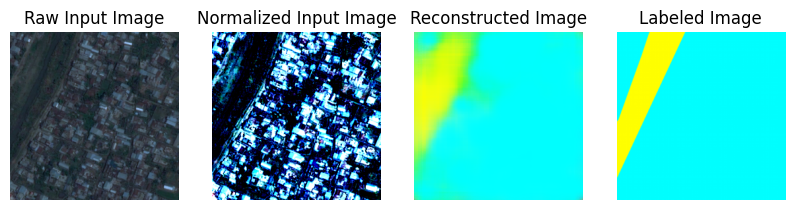

In [115]:
output_image(autoencoder, train_loader, device)

In [143]:
num_epochs = 250
learning_rate = 0.0008
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder_3_1()  # Instantiate your autoencoder model
criterion = nn.MSELoss()  # Define the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)  # Define the optimizer

formal_trial_1 = train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device)

Training Start:
Epoch 1/250, Train Loss: 0.179464611567949, Train Accuracy: 0.13850098322711252, Val Loss: 0.16092985229832785, Val Accuracy: 0.21608572037699986
Epoch 2/250, Train Loss: 0.14511606606997943, Train Accuracy: 0.28637554350655675, Val Loss: 0.14152173910822188, Val Accuracy: 0.3123173792370082
Epoch 3/250, Train Loss: 0.1332482099533081, Train Accuracy: 0.3321871072533259, Val Loss: 0.13907345277922495, Val Accuracy: 0.2961932865306489
Epoch 4/250, Train Loss: 0.12268214202240894, Train Accuracy: 0.392891356499408, Val Loss: 0.12768899436507905, Val Accuracy: 0.2379690396903765
Epoch 5/250, Train Loss: 0.11703568383267052, Train Accuracy: 0.39928871118817405, Val Loss: 0.11534968124968666, Val Accuracy: 0.3450382471871455
Epoch 6/250, Train Loss: 0.11142983013077785, Train Accuracy: 0.39799314595167995, Val Loss: 0.11955428762095315, Val Accuracy: 0.2781343082390209
Epoch 7/250, Train Loss: 0.10840911849548943, Train Accuracy: 0.4017121901594131, Val Loss: 0.1115275227597

KeyboardInterrupt: 